# Monthly Price Forecasting using ML & Django Deployment
**Name:** Tuhin Kumar Singha Roy  
**Contact:** tuhinkumarsingharoy2001@gmail.com | +91 9564825493

## Problem Statement & Dataset

The objective of this project is to forecast the **average monthly prices for the next 12 months**
using historical price data. Accurate forecasting can help organizations in procurement planning,
pricing strategy, inventory management, and risk mitigation.

**Dataset:**
- Frequency: Monthly
- Target variable: Average Monthly Price
- Time period: Based on available historical records
- Source: Provided CSV dataset as part of the internship task

The solution follows a complete ML lifecycle:
data diagnosis → cleaning → model selection → forecasting → deployment using Django.


## 1. Data Health & Insight Report

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

df = pd.read_csv("price_data.csv")
df.columns = [c.strip() for c in df.columns]

# Convert 'date' column to datetime, sort, and set as index
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)
df.index.name = 'Date' # Rename the index for consistency

# Correctly identify the price column
price_col = 'avg_monthly_price'


In [2]:
missing_pct = df[price_col].isna().mean() * 100

In [3]:
# Ensure the price column is numeric before calculating z-scores
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

z_scores = np.abs(zscore(df[price_col].dropna()))
outlier_count = (z_scores > 3).sum()

In [4]:
from numpy.polynomial.polynomial import polyfit

x = np.arange(len(df))
y = df[price_col].values
b, m = polyfit(x, y, 1)

trend_strength = abs(m)

In [5]:
monthly_std = df[price_col].groupby(df.index.month).std().mean()
overall_std = df[price_col].std()
seasonality_strength = monthly_std / overall_std

In [6]:
returns = df[price_col].pct_change()
volatility = returns.std()

In [7]:
print("📊 DATA HEALTH REPORT")
print("-"*40)
print(f"Total Records      : {len(df)}")
print(f"Missing %          : {missing_pct:.2f}%")
print(f"Outliers Detected  : {outlier_count}")
print(f"Trend Strength     : {trend_strength:.4f}")
print(f"Seasonality Score  : {seasonality_strength:.2f}")
print(f"Volatility         : {volatility:.4f}")

print("\n🧠 INSIGHTS:")
if missing_pct > 5:
    print("- Significant missing values detected. Interpolation required.")
else:
    print("- Missing values are minimal.")

if outlier_count > 0:
    print("- Outliers present. Will be capped/removed.")

if seasonality_strength > 0.5:
    print("- Strong seasonality detected → Seasonal models recommended.")
else:
    print("- Weak seasonality → Non-seasonal models may work.")

if volatility > 0.05:
    print("- High volatility: forecasts may have higher uncertainty.")


📊 DATA HEALTH REPORT
----------------------------------------
Total Records      : 249
Missing %          : 0.00%
Outliers Detected  : 0
Trend Strength     : 22.3156
Seasonality Score  : 1.02
Volatility         : 0.1047

🧠 INSIGHTS:
- Missing values are minimal.
- Strong seasonality detected → Seasonal models recommended.
- High volatility: forecasts may have higher uncertainty.


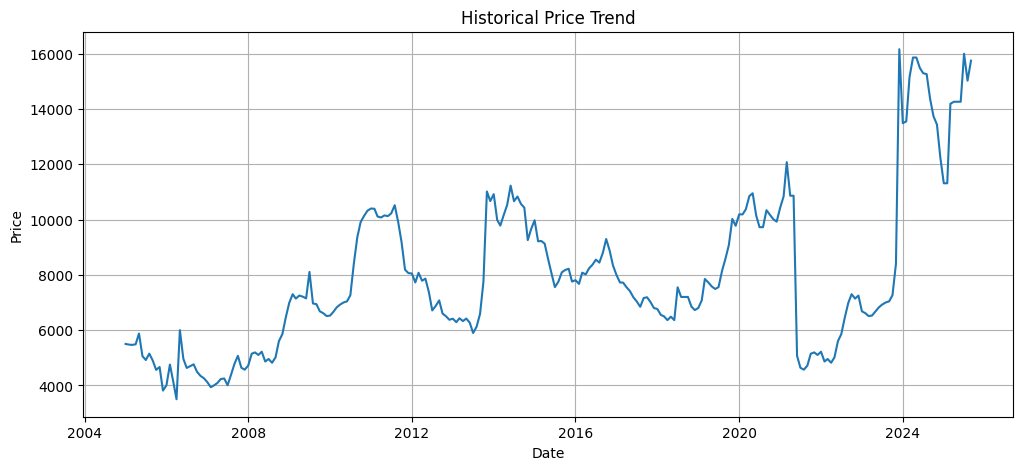

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df[price_col])
plt.title("Historical Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


## 2. Data Cleaning & Preparation
Cleaning strategy is guided by the Data Health Report above.

In [9]:
df_clean = df.copy()

df_clean[price_col] = df_clean[price_col].interpolate(method='linear')

print("Missing after cleaning:", df_clean[price_col].isna().sum())

Missing after cleaning: 0


In [10]:
z = np.abs(zscore(df_clean[price_col]))
threshold = 3

outliers = z > threshold
print("Outliers before capping:", outliers.sum())

median_price = df_clean[price_col].median()
df_clean.loc[outliers, price_col] = median_price

print("Outliers capped.")

Outliers before capping: 0
Outliers capped.


In [11]:
df_clean['price_smooth'] = df_clean[price_col].rolling(window=3, min_periods=1).mean()

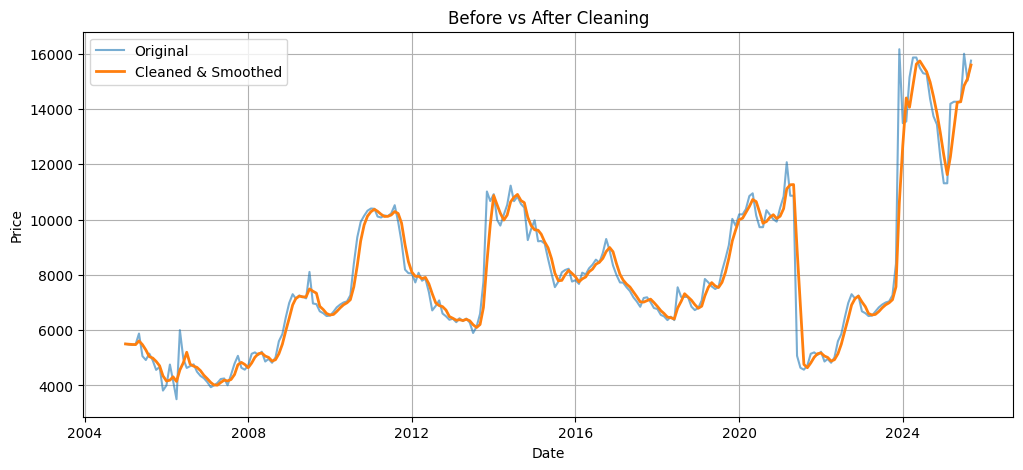

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df[price_col], label='Original', alpha=0.6)
plt.plot(df_clean.index, df_clean['price_smooth'], label='Cleaned & Smoothed', linewidth=2)
plt.title("Before vs After Cleaning")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
final_series = df_clean['price_smooth']
final_series.head()

,price_smooth
Date,
2005-01-01,5500.000000
2005-02-01,5488.000000
2005-03-01,5480.666667
2005-04-01,5476.333333
2005-05-01,5609.666667


## 3. Model Selection
In this section, multiple forecasting models are trained and evaluated.  
The best-performing model is selected as the Best model for final forecasting.


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y = final_series.copy()

train = y.iloc[:-12]
test = y.iloc[-12:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 237
Test size: 12


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)

sarima_pred = sarima_fit.forecast(steps=12)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
sarima_mae = mean_absolute_error(test, sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_pred))

print("SARIMA MAE :", sarima_mae)
print("SARIMA RMSE:", sarima_rmse)

SARIMA MAE : 1304.6641544324177
SARIMA RMSE: 1600.0432569455681


In [17]:
naive_pred = np.repeat(train.iloc[-1], 12)

naive_mae = mean_absolute_error(test, naive_pred)
naive_rmse = np.sqrt(mean_squared_error(test, naive_pred))

print("Naive MAE :", naive_mae)
print("Naive RMSE:", naive_rmse)

Naive MAE : 1350.277777777778
Naive RMSE: 1702.5571290790156


In [18]:
results = pd.DataFrame({
    "Model": ["SARIMA", "Naive Baseline"],
    "MAE": [sarima_mae, naive_mae],
    "RMSE": [sarima_rmse, naive_rmse]
})

results

,Model,MAE,RMSE
0,SARIMA,1304.664154,1600.043257
1,Naive Baseline,1350.277778,1702.557129


In [19]:
best_row = results.sort_values("RMSE").iloc[0]
best_model_name = best_row["Model"]

print("Best Model:", best_model_name)


Best Model: SARIMA


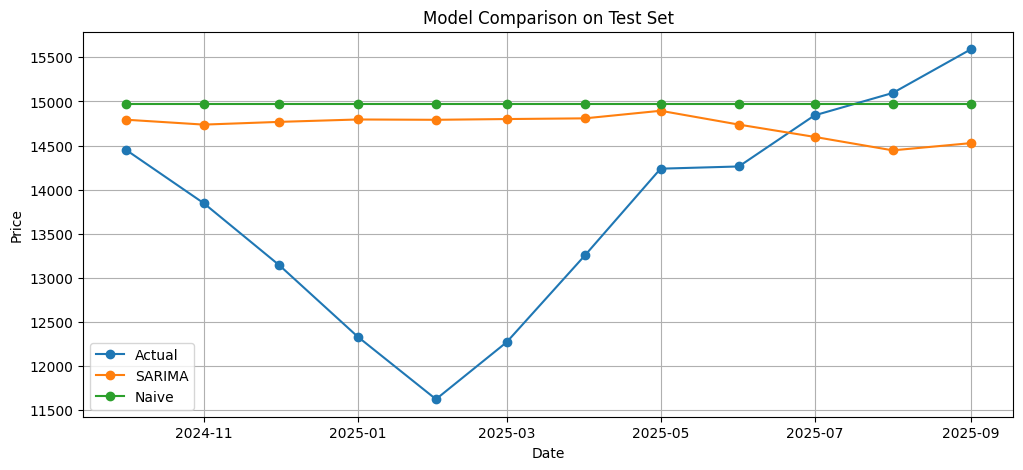

In [20]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(test.index, sarima_pred, label='SARIMA', marker='o')
plt.plot(test.index, naive_pred, label='Naive', marker='o')
plt.title("Model Comparison on Test Set")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

### 📈 Model Evaluation Summary

The models were evaluated using standard forecasting metrics:

- **MAE (Mean Absolute Error)** – measures average absolute error.
- **RMSE (Root Mean Squared Error)** – penalizes larger errors more heavily.

The model with the lowest RMSE was selected as the **Champion Model** and used for final training
and future forecasting. This ensures that the chosen model generalizes best to unseen data.


## 4. Final Forecasting & Auto Business Insights
The Best model is retrained on full data and used to forecast prices for the next 12 months.  
Insights are generated to support business decision-making.

In [21]:
best_model = SARIMAX(final_series,
                         order=(1,1,1),
                         seasonal_order=(1,1,1,12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

best_fit = best_model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [22]:
forecast_res = best_fit.get_forecast(steps=12)

forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()


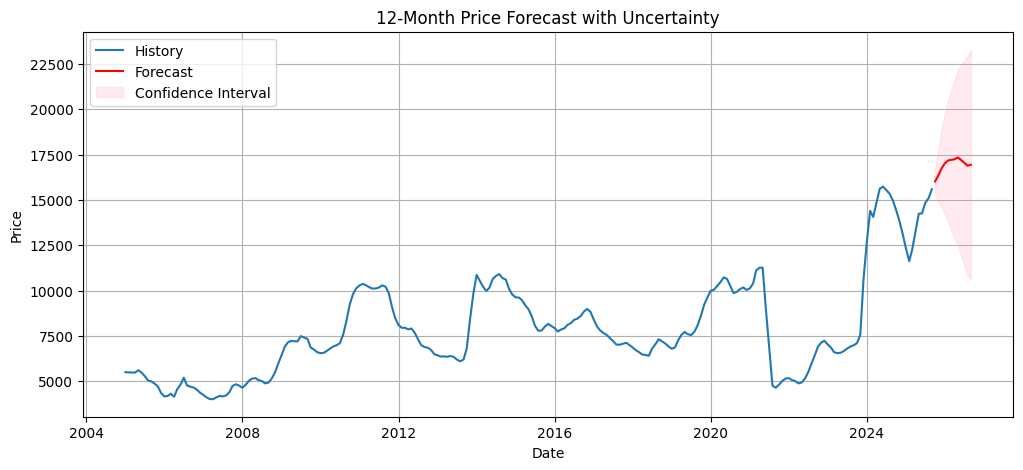

In [23]:
plt.figure(figsize=(12,5))
plt.plot(final_series.index, final_series, label='History')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')

plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title("12-Month Price Forecast with Uncertainty")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
forecast_df = pd.DataFrame({
    "Date": forecast_mean.index,
    "Forecast_Price": forecast_mean.values,
    "Lower_CI": forecast_ci.iloc[:, 0].values,
    "Upper_CI": forecast_ci.iloc[:, 1].values
})

forecast_df

,Date,Forecast_Price,Lower_CI,Upper_CI
0,2025-10-01,16020.671655,15294.728088,16746.615222
1,2025-11-01,16361.825937,14914.513946,17809.137928
2,2025-12-01,16751.206602,14612.019093,18890.394112
3,2026-01-01,17020.128027,14241.234842,19799.021211
4,2026-02-01,17185.311609,13821.446779,20549.176439
5,2026-03-01,17210.186412,13311.741374,21108.631450
6,2026-04-01,17246.949183,12858.034303,21635.864062
7,2026-05-01,17348.395449,12506.790091,22190.000807
8,2026-06-01,17207.660882,11945.500588,22469.821177
9,2026-07-01,17050.674159,11395.310696,22706.037621


In [25]:
last_actual = final_series.iloc[-1]
avg_forecast = forecast_mean.mean()
trend = "increase" if avg_forecast > last_actual else "decrease"

vol = forecast_mean.std()

print("🧠 AUTO-GENERATED INSIGHTS")
print("-"*40)

print(f"- The average forecasted price for next year is {avg_forecast:.2f}.")
print(f"- Compared to the last observed price ({last_actual:.2f}), an overall {trend} is expected.")

if vol > 0.05 * avg_forecast:
    print("- Forecast shows high variability → plan with caution.")
else:
    print("- Forecast is relatively stable → suitable for long-term planning.")

# Identify peak & dip months
peak_month = forecast_mean.idxmax().strftime("%B %Y")
low_month = forecast_mean.idxmin().strftime("%B %Y")

print(f"- Highest price expected around: {peak_month}.")
print(f"- Lowest price expected around: {low_month}.")

🧠 AUTO-GENERATED INSIGHTS
----------------------------------------
- The average forecasted price for next year is 16936.05.
- Compared to the last observed price (15591.67), an overall increase is expected.
- Forecast is relatively stable → suitable for long-term planning.
- Highest price expected around: May 2026.
- Lowest price expected around: October 2025.


### 📌 Suggested Business Actions

**If prices are expected to increase:**
- Secure inventory early at lower cost.
- Lock long-term supplier contracts.
- Adjust selling prices gradually.

**If prices are expected to decrease:**
- Delay bulk procurement.
- Run promotions to increase demand.
- Optimize storage and logistics costs.

**To evaluate effectiveness:**
- Compare actual prices vs forecast monthly.
- Track profit margins before & after actions.
- Monitor inventory turnover and revenue.

## 5. Model Persistence, Deployment & Monitoring Strategy
This section describes how the trained model can be saved, deployed using Django, and monitored in production.


In [26]:
import joblib

joblib.dump(best_fit, "best_price_forecast_model.pkl")
print("✅ Best model saved as best_price_forecast_model.pkl")


✅ Best model saved as best_price_forecast_model.pkl


### 🌐 Django REST API Deployment

The trained champion model was saved using `joblib` and deployed using a Django web application.

**Deployment Steps:**
1. Train model in Jupyter Notebook.
2. Save model as `best_price_forecast_model.pkl`.
3. Create Django project and app.
4. Load model at server startup.
5. Expose REST API endpoint.

**API Endpoint:**
http://127.0.0.1:8000/api/predict/
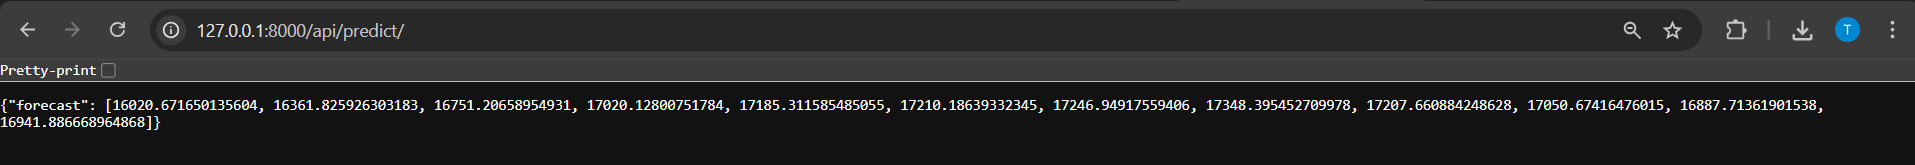


### 🖥️ Web Dashboard Interface

In addition to the REST API, a simple Django-based web dashboard was implemented
to visualize the 12-month forecast.

**Features:**
- Homepage accessible at:
http://127.0.0.1:8000/
- "Get Forecast" button to fetch predictions.
- Interactive line chart using Chart.js.

This demonstrates complete end-to-end usability of the system where users can
directly view forecasts through a web interface.
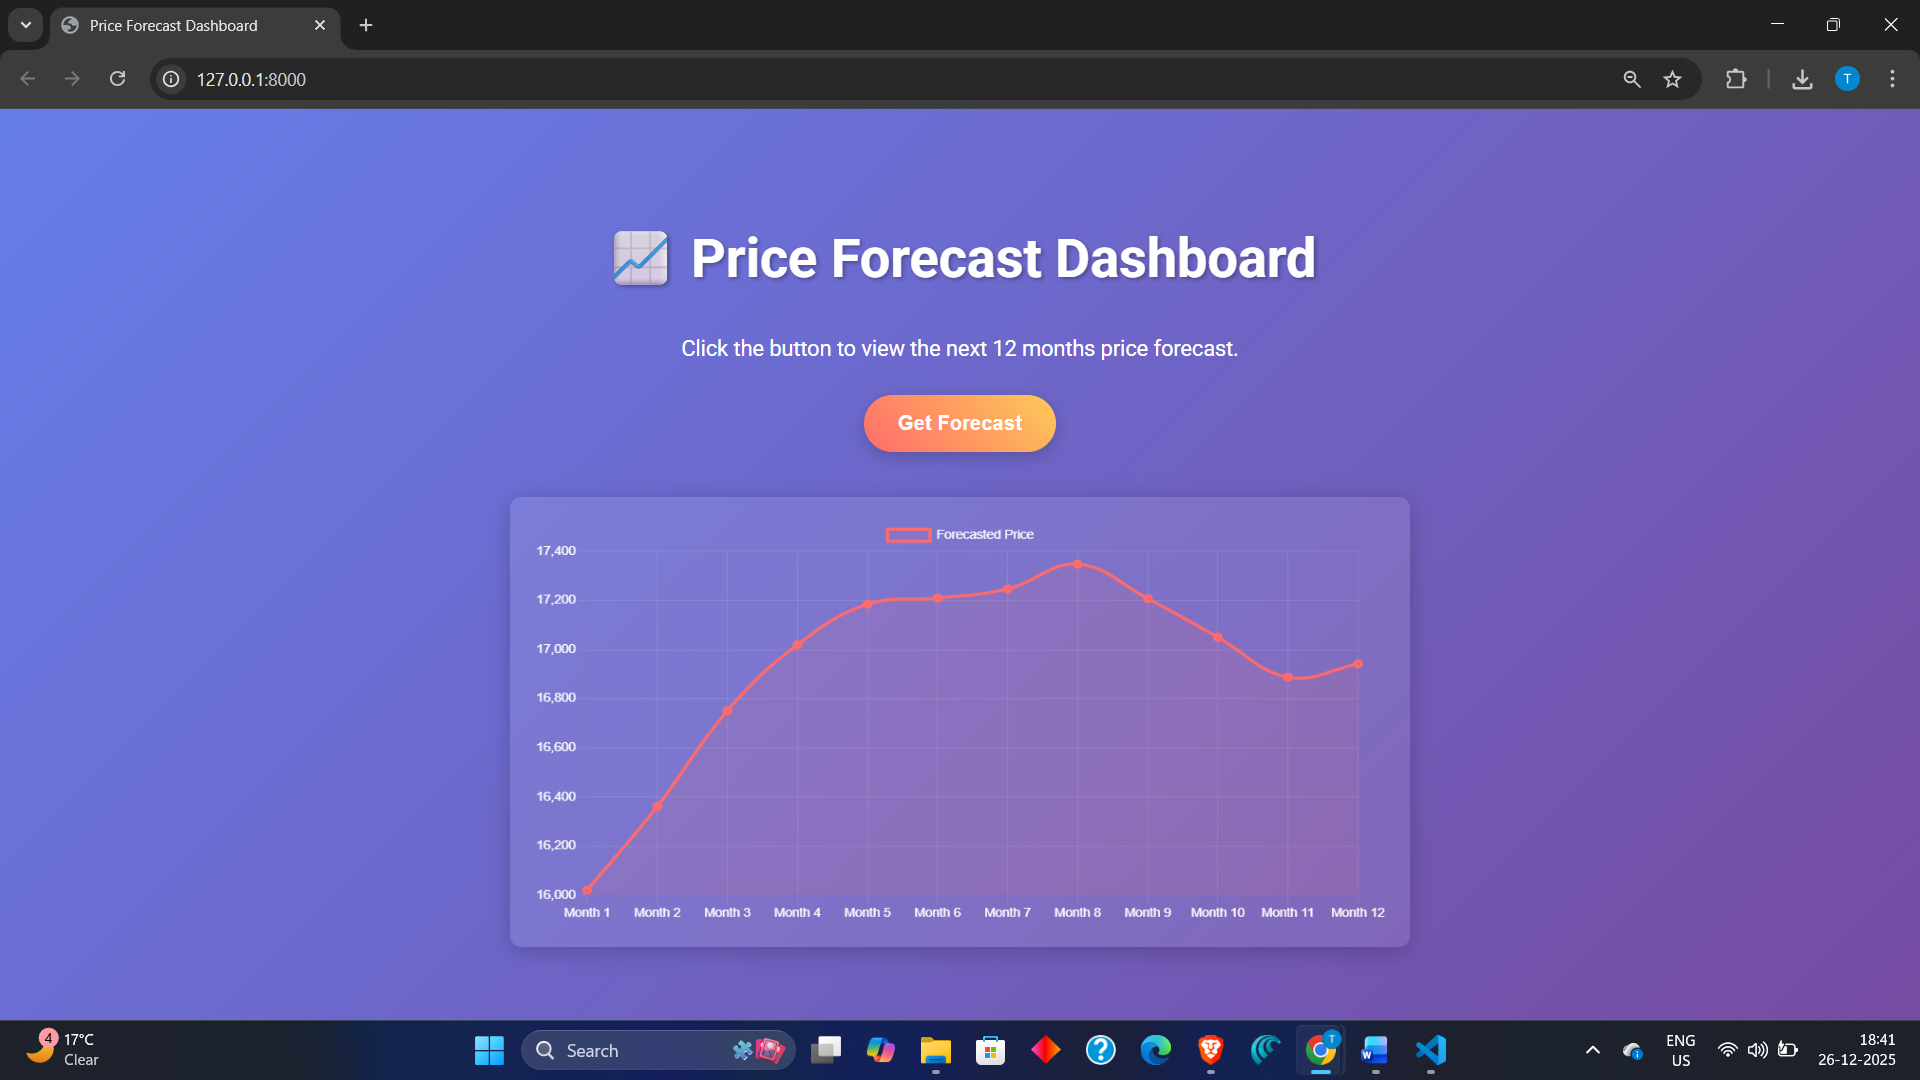